In [1]:
"""
End to End inference with tacotron2
"""

from tacotron2.model import Tacotron2
from tacotron2.hparams import Hparams as hparams_s
from tacotron2.text import text_to_sequence
from tacotron2.audio_processing import _custom_griffin_lim, _denormalize, melspectrogram
from env import AttrDict, build_env
from models import Generator
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
import json
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

with open('cp_hifigan/config.json', 'r', encoding='utf8') as j:
    hparams_v = json.loads(j.read())
    hparams_v = AttrDict(hparams_v)

def get_models(synthesizer_checkpoint_path, vocoder_checkpoint_path, hparams_s, hparams_v):
    model_s = Tacotron2(hparams_s)
    checkpoint_s = torch.load(synthesizer_checkpoint_path, map_location=f'cuda:{0}')
    checkpoint_s['state_dict'] = {key.replace("module.", ""): value
                                  for key, value in checkpoint_s['state_dict'].items()}
    model_s.load_state_dict(checkpoint_s['state_dict'], strict=False)
    model_s = model_s.cuda(0)
    
    model_v = Generator(hparams_v)
    checkpoint_v = torch.load(vocoder_checkpoint_path, map_location=f'cuda:{0}')
    checkpoint_v['generator'] = {key.replace("module.", ""): value
                                  for key, value in checkpoint_v['generator'].items()}
    model_v.load_state_dict(checkpoint_v['generator'], strict=False)
    model_v = model_v.cuda(0)
    
    return model_s, model_v

def get_text(text):
    sequences = torch.LongTensor(text_to_sequence(text)).unsqueeze(0)
    sequences = sequences.cuda(0)
    return sequences

def synthesis(model_s, model_v, text):
    model_s.eval()
    model_v.eval()
    with torch.no_grad():
        outputs = model_s.inference(sequences)
        mel, gate, align = outputs[1:]
        o = model_v(mel)
    return o, mel, gate, align

def visualize(o, mel, gate, align, hparams_s):
    o_mel = melspectrogram(o.squeeze().detach().cpu().numpy(), hparams_s)
    
    print("mel with hifi-gan")
    plt.imshow(o_mel, aspect='auto', origin='lower')
    plt.show()
    
    print("mel with tacotron2")
    plt.imshow(mel.squeeze(0).detach().cpu().numpy(), aspect='auto', origin='lower')
    plt.show()

    plt.plot(gate.squeeze(0).detach().cpu().numpy())
    plt.show()

    plt.imshow(align.squeeze(0).detach().cpu().numpy().T, aspect='auto', origin='lower')
    plt.show()

    mel_denorm = _denormalize(mel.squeeze(0).detach().cpu().numpy(), hparams_s)

    hparams_s.griffin_lim_iters = 60
    audio = _custom_griffin_lim(mel_denorm, hparams_s)
    
    print("audio with griffin-lim")
    display(ipd.Audio(audio, rate=hparams_s.sampling_rate, normalize=True, autoplay=False))
    
    print("audio with hifi-gan")
    o = o.squeeze().detach().cpu().numpy()
    display(ipd.Audio(o, rate=hparams_v.sampling_rate, normalize=True, autoplay=False))


In [2]:
"""
synthesizer(tacotron2) inference
"""

synthesizer_checkpoint_path = 'tacotron2/data/kss_v1/model_state/checkpoint_70000'
vocoder_checkpoint_path = 'cp_hifigan/g_00015000'
model_s, model_v = get_models(
    synthesizer_checkpoint_path, 
    vocoder_checkpoint_path, 
    hparams_s=hparams_s,
    hparams_v=hparams_v
)

input_text = '안녕하세요? 만나서 반갑습니다.'
sequences = get_text(input_text)

o, mel, gate, align = synthesis(model_s, model_v, sequences)

mel with hifi-gan


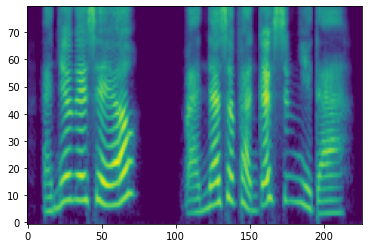

mel with tacotron2


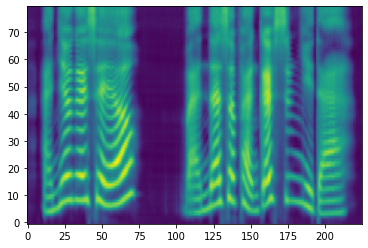

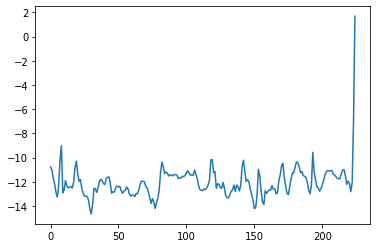

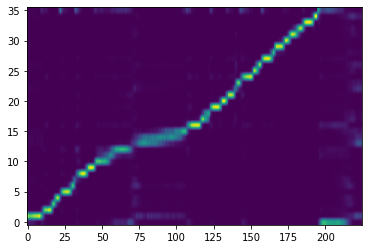

audio with griffin-lim


audio with hifi-gan


In [3]:
visualize(o, mel, gate, align, hparams_s)